# 車輪型の倒立振子の制御

## ライブラリのインポート

In [53]:
#シンボリック計算ライブラリsympyをインポート
import sympy as sp
#数値計算ライブラリnumpyをインポート
import numpy as np


#科学技術計算ライブラリscipyの特に機械力学のためのモジュールphysics.mechanicsをインポート
from sympy.physics.mechanics import dynamicsymbols, LagrangesMethod, ReferenceFrame,Point, RigidBody, outer, Lagrangian
#微分方程式を解くためのモジュールsolve_ivpをインポート
from scipy.integrate import solve_ivp
from scipy import linalg

#描画ライブラリmatplotlibをインポート, およびアニメーションのためのモジュールをインポート
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## 車輪と振子のモデル化

車輪と振子のパラメータを定義

In [54]:
#幾何的なパラメータの定義
a,l,w=sp.symbols('a l w')
# a is the radius of the wheel
# l is the vertical distance between the wheel and pendulum
# w is the horizontal distance between the wheel and pendulum

#物理的なパラメータの定義
m_p,m_w,I_p,I_w,g,mu_p,mu_w,g=sp.symbols('m_p m_w I_p I_w g mu_p mu_w g')
# m_p is the mass of the pendulum
# m_w is the mass of the wheel
# I_p is the moment of inertia of the pendulum
# I_w is the moment of inertia of the wheel
# g is the acceleration due to gravity
theta_offset=sp.symbols('theta_offset')
theta_offset=sp.atan(w/l)

# 角度パラメータの定義
theta,phi=dynamicsymbols('theta phi')
thetadot,phidot=dynamicsymbols('theta phi',1)

# 時間の定義
t=sp.symbols('t')

座標系の定義

In [55]:
#絶対座標系Nを定義
N=ReferenceFrame('N')
O=Point('O')
O.set_vel(N,0)

#振子の座標系を定義
N_p=N.orientnew('N_p','Axis',[theta+theta_offset,N.y])#thetaだけ回転
N_p.set_ang_vel(N,thetadot*N.y)#角速度はthetadotだけ


#車輪の座標系を作成
N_w=N_p.orientnew('N_w','Axis',[phi,N_p.y])#N_pに対してphiだけ回転
N_w.set_ang_vel(N_p,phidot*N_p.y)#角速度はphidotだけ

重心と剛体の定義

In [56]:
#振子の重心と剛体の定義
C_p=Point('C_p')
I_p_tensor=I_p*outer(N.y,N.y)#慣性テンソル
P=RigidBody('P',C_p,N_p,m_p,(I_p_tensor,C_p))

#車輪の重心と剛体の定義
C_w=Point('C_w')
I_w_tensor=I_w*outer(N_w.y,N_w.y)#慣性テンソル
W=RigidBody('W',C_w,N_w,m_w,(I_w_tensor,C_w))

重心位置の設定

In [57]:
#重心位置の設定
C_p.set_pos(C_w,l*(sp.sin(theta+theta_offset)*N.x+sp.cos(theta+theta_offset)*N.z)+w*(sp.cos(theta+theta_offset)*N.x-sp.sin(theta+theta_offset)*N.z))
C_w.set_pos(O,a*((theta+theta_offset+phi)*N.x+N.z))

速度の設定

In [58]:
C_p.set_vel(N,C_p.pos_from(O).dt(N))
C_w.set_vel(N,C_w.pos_from(O).dt(N))

## 運動方程式の計算

運動エネルギーの計算と表示

In [59]:
print('kinetic energy of the pendulum')
display(P.kinetic_energy(N))

print('kinetic energy of the wheel')
display(W.kinetic_energy(N))

kinetic energy of the pendulum


I_p*Derivative(theta(t), t)**2/2 + m_p*((-l*sin(theta(t) + atan(w/l))*Derivative(theta(t), t) - w*cos(theta(t) + atan(w/l))*Derivative(theta(t), t))**2 + (a*(Derivative(phi(t), t) + Derivative(theta(t), t)) + l*cos(theta(t) + atan(w/l))*Derivative(theta(t), t) - w*sin(theta(t) + atan(w/l))*Derivative(theta(t), t))**2)/2

kinetic energy of the wheel


I_w*(Derivative(phi(t), t) + Derivative(theta(t), t))*Derivative(phi(t), t)/2 + I_w*(Derivative(phi(t), t) + Derivative(theta(t), t))*Derivative(theta(t), t)/2 + a**2*m_w*(Derivative(phi(t), t) + Derivative(theta(t), t))**2/2

ポテンシャルエネルギーの計算と表示

In [60]:
#振子のポテンシャルエネルギー
P.potential_energy=m_p*g*(l*sp.cos(theta+theta_offset)-w*sp.sin(theta+theta_offset))
display(P.potential_energy)

g*m_p*(l*cos(theta(t) + atan(w/l)) - w*sin(theta(t) + atan(w/l)))

ラグランジアンの計算

In [61]:
#ラグランジアン
L=Lagrangian(N,P,W)
display(L)

I_p*Derivative(theta(t), t)**2/2 + I_w*(Derivative(phi(t), t) + Derivative(theta(t), t))*Derivative(phi(t), t)/2 + I_w*(Derivative(phi(t), t) + Derivative(theta(t), t))*Derivative(theta(t), t)/2 + a**2*m_w*(Derivative(phi(t), t) + Derivative(theta(t), t))**2/2 - g*m_p*(l*cos(theta(t) + atan(w/l)) - w*sin(theta(t) + atan(w/l))) + m_p*((-l*sin(theta(t) + atan(w/l))*Derivative(theta(t), t) - w*cos(theta(t) + atan(w/l))*Derivative(theta(t), t))**2 + (a*(Derivative(phi(t), t) + Derivative(theta(t), t)) + l*cos(theta(t) + atan(w/l))*Derivative(theta(t), t) - w*sin(theta(t) + atan(w/l))*Derivative(theta(t), t))**2)/2

一般化座標の設定

In [62]:
#一般化座標の設定
q=sp.Matrix([theta,phi])

一般化力の設定

In [63]:
#一般化力の設定
#制御トルク
tau=dynamicsymbols('tau')
f_control=[(N_p,-tau*N_p.y),(N_w,tau*N_w.y)]

#摩擦トルク
tau_fp,tau_fw=sp.symbols('tau_fp tau_fw')
tau_fp=mu_p*phidot
tau_fw = -mu_p * phidot - mu_w * (thetadot + phidot)
display(tau_fw)
f_dissipation = [(N_p, tau_fp * N_p.y), (N_w, tau_fw * N_w.y)]

#外乱が掛かる点
P_d=Point('P_d')
P_d.set_pos(C_p,l*N_p.z+w*N_p.x)
P_d.set_vel(N,P_d.pos_from(O).dt(N))
#外乱
f_d=dynamicsymbols('f_d')
f_disturbance=[(P_d,f_d*N.x)]

f=dynamicsymbols('f')
f=f_control+f_dissipation+f_disturbance
display(f)

-mu_p*Derivative(phi(t), t) - mu_w*(Derivative(phi(t), t) + Derivative(theta(t), t))

[(N_p, - tau(t)*N_p.y),
 (N_w, tau(t)*N_w.y),
 (N_p, mu_p*Derivative(phi(t), t)*N_p.y),
 (N_w,
  (-mu_p*Derivative(phi(t), t) - mu_w*(Derivative(phi(t), t) + Derivative(theta(t), t)))*N_w.y),
 (P_d, f_d(t)*N.x)]

運動方程式の計算

In [64]:
LM=LagrangesMethod(L,q,forcelist=f,frame=N)
eom=LM.form_lagranges_equations()
display(eom)

Matrix([
[I_p*Derivative(theta(t), (t, 2)) + I_w*(Derivative(phi(t), (t, 2)) + Derivative(theta(t), (t, 2)))/2 + I_w*Derivative(phi(t), (t, 2))/2 + I_w*Derivative(theta(t), (t, 2))/2 + a**2*m_w*(2*Derivative(phi(t), (t, 2)) + 2*Derivative(theta(t), (t, 2)))/2 + g*m_p*(-l*sin(theta(t) + atan(w/l)) - w*cos(theta(t) + atan(w/l))) - l*f_d(t)*cos(theta(t) + atan(w/l)) - m_p*((-2*l*sin(theta(t) + atan(w/l))*Derivative(theta(t), t) - 2*w*cos(theta(t) + atan(w/l))*Derivative(theta(t), t))*(a*(Derivative(phi(t), t) + Derivative(theta(t), t)) + l*cos(theta(t) + atan(w/l))*Derivative(theta(t), t) - w*sin(theta(t) + atan(w/l))*Derivative(theta(t), t)) + (-l*sin(theta(t) + atan(w/l))*Derivative(theta(t), t) - w*cos(theta(t) + atan(w/l))*Derivative(theta(t), t))*(-2*l*cos(theta(t) + atan(w/l))*Derivative(theta(t), t) + 2*w*sin(theta(t) + atan(w/l))*Derivative(theta(t), t)))/2 + m_p*((-2*l*sin(theta(t) + atan(w/l)) - 2*w*cos(theta(t) + atan(w/l)))*(-l*sin(theta(t) + atan(w/l))*Derivative(theta(t), (t

状態方程式の計算

In [65]:
#状態方程式
state_eqs=LM.rhs()
display(state_eqs)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

状態方程式の線形化

In [66]:
#動作点の設定
op_point={theta:-theta_offset,thetadot:0,phi:0,phidot:0}

#線形化
kwargs = {'q_ind': [theta, phi], 'qd_ind': [thetadot, phidot],'A_and_B': True, 'op_point': op_point, 'simplify': True}
A, B, inp_vec = LM.linearize(**kwargs)

In [67]:
#行列の表示
display(A)
display(B)
display(inp_vec)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    0, 0,                                                                                                                                                                          1,                                                                                                                                                                                                                             0],
[                                       

Matrix([
[                                                                                                                                                                                                                     0,                                                                                                                                                                     0],
[                                                                                                                                                                                                                     0,                                                                                                                                                                     0],
[                                                    l*(2*I_w + a**2*m_p + 2*a**2*m_w)/(I_p*I_w + I_p*a**2*m_p + I_p*a**2*m_w + I_w*l**2*m_p + I_w*m_p*w**2 + a**2*l**2*m_p*m_w + a**2*m_p**2*w**2 + a**2*m_p*m_w*w**2),     

Matrix([
[f_d(t)],
[tau(t)]])

## 数値計算
ここからは値を代入して計算していきます

In [216]:
class Param:
    def __init__(self):
        self.a=0.15
        self.l=0.50
        self.w=0.05
        self.m_p=1.5
        self.m_w=0.2
        self.I_p=self.m_p*self.m_p*self.l**2/3
        self.I_w=self.m_w*self.m_w*self.a**2/2
        self.g=9.8
        self.mu_p=0.05
        self.mu_w=0.05

In [217]:
#数値計算用のパラメータ
par=Param()

最適レギュレータの設計

In [218]:
#lqrの計算を行う関数
def lqr(A, B, Q, R):
    '''
    最適レギュレータ計算
    '''
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R).dot(B.T).dot(P)
    E = linalg.eigvals(A - B.dot(K))

    return P, K, E

In [363]:
#Q,Rの設定
Q=np.diag([1,1,500,1])
R=np.diag([1,1])

In [364]:
#A,Bに数値を代入
A_num=A.subs([(a,par.a),(l,par.l),(w,par.w),(m_p,par.m_p),(m_w,par.m_w),(I_p,par.I_p),(I_w,par.I_w),(g,par.g),(mu_p,par.mu_p),(mu_w,par.mu_w),(f_d,0),(tau,0),(theta.diff(t,2),0),(phi.diff(t,2),0)])
B_num=B.subs([(a,par.a),(l,par.l),(w,par.w),(m_p,par.m_p),(m_w,par.m_w),(I_p,par.I_p),(I_w,par.I_w),(g,par.g),(mu_p,par.mu_p),(mu_w,par.mu_w),(f_d,0),(tau,0),(theta.diff(t,2),0),(phi.diff(t,2),0)])
display(A_num)
display(B_num)

Matrix([
[                0, 0,                 1,                 0],
[                0, 0,                 0,                 1],
[ 30.7254830477579, 0, 0.607607242678333,  1.42423137683801],
[-120.043747721473, 0, -3.66589703082594, -8.14841819581157]])

Matrix([
[                0,                 0],
[                0,                 0],
[ 2.35751610159193, -16.3324826831936],
[-5.33479159071576,  89.6504232997124]])

In [365]:
# A,B,Q,Rをarrayに変換
A_np_a = np.asarray(A_num, dtype=float)
B_np_a = np.asarray(B_num, dtype=float)
Q_np_a = np.asarray(Q, dtype=float)
R_np_a = np.asarray(R, dtype=float)

フィードバックゲインKの計算

In [366]:
P_lqr, K_lqr, E_lqr = lqr(A_np_a, B_np_a, Q_np_a, R_np_a)
display(K_lqr)

array([[  8.78514082,   0.93059675,   8.71789968,   1.02224053],
       [ -7.04453294,   0.36604601, -20.90773883,   0.27186038]])

トルクと外乱の関数定義

In [367]:
#f_d_funcの定義
def f_d_func(t):
    return 0

#tau_funcの定義
def tau_func(t,y):
    return k_p*(y[0])+k_d*y[2]+10*y[1]

def tau_func_lqr(t,y):
    return (-K_lqr.dot(y))[1]

### 非線形状態方程式を関数化

In [368]:
#numpy形式の関数に変換
f_np=state_eqs.subs([(a,par.a),(l,par.l),(w,par.w),(m_p,par.m_p),(m_w,par.m_w),(I_p,par.I_p),(I_w,par.I_w),(g,par.g),(mu_p,par.mu_p),(mu_w,par.mu_w)])
display(f_np)
f_np_nu=sp.lambdify([thetadot,phidot,theta,phi,f_d,tau],f_np,'numpy')

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [369]:
#numpy形式の関数に変換
def f_np_func(t,y):
    ret=f_np_nu(y[2],y[3],y[0],y[1],f_d_func(t),tau_func_lqr(t,y))
    #ret=f_np_nu(y[2],y[3],y[0],y[1],f_d_func(t),tau_func(t,y))
    return np.ravel(ret)
    #fn_np_temp=f_np.subs([(thetadot,y[2]),(phidot,y[3]),(theta,y[0]),(phi,y[1]),(f_d,f_d_func(t)),(tau,tau_func(t,y))])
    #return [fn_np_temp[0],fn_np_temp[1],fn_np_temp[2],fn_np_temp[3]]
#classで書きたいよね, めっちゃきしょいし

## 数値積分

In [370]:
#ゲインの設定
k_p=1.0
k_d=1.0

#時間間隔の設定
tdiv=50
#時間の範囲の設定
t_span=[0,5]
#アニメーションのfps
afps=tdiv/(t_span[1]-t_span[0])
#初期値の設定
y0=[-theta_offset.subs([(l,par.l),(w,par.w)]),0.0,0.0,0]

#時間の離散化
t_eval = np.linspace(*t_span,tdiv)

#数値計算
sol=solve_ivp(f_np_func,t_span,y0,method='RK45',t_eval=t_eval)


In [371]:
y=sol.y.T
np.shape(y)

(50, 4)

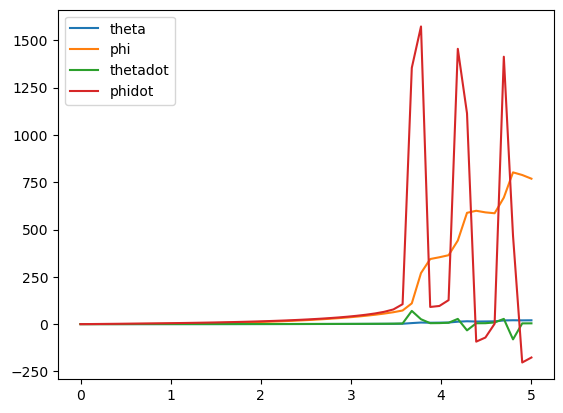

In [372]:
#4つの値を重ねてプロット
fig,ax=plt.subplots()
ax.plot(t_eval,sol.y[0])
ax.plot(t_eval,sol.y[1])
ax.plot(t_eval,sol.y[2])
ax.plot(t_eval,sol.y[3])
#凡例を追加
plt.legend(['theta','phi','thetadot','phidot'])
plt.show()


# アニメーションの作成

In [373]:
#データの整理
y[:,0]=sol.y[0]
y[:,1]=sol.y[1]
y[:,2]=sol.y[2]
y[:,3]=sol.y[3]

x_w=par.a*(y[:,0]+y[:,1])#車輪のx座標
atheta=y[:,0]#振子の角度
aphi=y[:,1]#車輪の角度

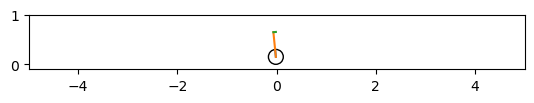

In [374]:
#車輪の描写
#半径par.aの円を描写
#座標は(x_w,par.a)
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-5, 5)
ax.set_ylim(-0.1, 1)
circle = plt.Circle((x_w[0], par.a), par.a, fill=False)
ax.add_artist(circle)
#車輪にしるしをつける
line_w, = ax.plot([x_w[0], par.a], [x_w[0], 2*par.a])

#振子の描写
#振子の先端の座標は(x_w,par.a)
#振子の中心の座標は(x_w+par.l*np.sin(atheta),par.a-par.l*np.cos(atheta))
line, = ax.plot([x_w[0], x_w[0]+par.l*np.sin(atheta[0])], [par.a, par.a+par.l*np.cos(atheta[0])])
line2,= ax.plot([x_w[0]+par.l*np.sin(atheta[0]),x_w[0]+par.l*np.sin(atheta[0])+par.w*np.cos(atheta[0])], [par.a+par.l*np.cos(atheta[0]),par.a+par.l*np.cos(atheta[0])-par.w*np.sin(atheta[0])])

#アニメーションの関数
def update(num):
    #車輪を動かす
    circle.center = (x_w[num], par.a)
    line_w.set_xdata([x_w[num], x_w[num]+par.a*np.sin(atheta[num]+aphi[num])])
    line_w.set_ydata([par.a, par.a*(1+np.cos(atheta[num]+aphi[num]))])
    #振子を動かす
    line.set_xdata([x_w[num], x_w[num]+par.l*np.sin(atheta[num])])
    line.set_ydata([par.a, par.a+par.l*np.cos(atheta[num])])
    line2.set_xdata([x_w[num]+par.l*np.sin(atheta[num]),x_w[num]+par.l*np.sin(atheta[num])+par.w*np.cos(atheta[num])])
    line2.set_ydata([par.a+par.l*np.cos(atheta[num]),par.a+par.l*np.cos(atheta[num])-par.w*np.sin(atheta[num])])

    return line , circle,line_w,line2

ani = animation.FuncAnimation(fig, update, frames = len(t_eval), interval = (t_eval[1] - t_eval[0]) * 20 * 1000, blit = True)
plt.show()
ani.save('Simulation.gif', writer='pillow', fps=afps)
